In [361]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
import keras_tuner as kt
from keras.layers import LSTM, Dense, Dropout
from keras import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import datetime as dt

## Step 1

## 1. a

Let us download the data for the Titan stock

In [366]:
stock_data = yf.Ticker("TITAN.NS").history(start="2017-01-01", end="2024-12-31")

In [368]:
stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-02 00:00:00+05:30,315.502586,322.552096,312.193610,320.298187,656084,0.0,0.0
2017-01-03 00:00:00+05:30,327.060050,340.104093,325.285672,333.917755,2773103,0.0,0.0
2017-01-04 00:00:00+05:30,336.075739,347.153596,334.924812,344.947601,2371009,0.0,0.0
2017-01-05 00:00:00+05:30,345.762851,346.721971,340.919305,343.412994,1187872,0.0,0.0
2017-01-06 00:00:00+05:30,344.324149,348.160630,338.185786,340.679504,1089982,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-23 00:00:00+05:30,3378.100098,3406.300049,3336.649902,3396.949951,691202,0.0,0.0
2024-12-24 00:00:00+05:30,3385.350098,3419.000000,3338.199951,3353.399902,485245,0.0,0.0
2024-12-26 00:00:00+05:30,3365.000000,3371.850098,3312.649902,3323.050049,637094,0.0,0.0


In [370]:
stock_data.head() #first look at the data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-02 00:00:00+05:30,315.502586,322.552096,312.193610,320.298187,656084,0.0,0.0
2017-01-03 00:00:00+05:30,327.060050,340.104093,325.285672,333.917755,2773103,0.0,0.0
2017-01-04 00:00:00+05:30,336.075739,347.153596,334.924812,344.947601,2371009,0.0,0.0
2017-01-05 00:00:00+05:30,345.762851,346.721971,340.919305,343.412994,1187872,0.0,0.0
2017-01-06 00:00:00+05:30,344.324149,348.160630,338.185786,340.679504,1089982,0.0,0.0


Let us consider the closing prices for the analysis and model building to follow.

In [373]:
stock_prices = stock_data["Close"]

Let us perform some exploratory analysis on the closing prices.

In [376]:
stock_prices.describe() #summary statistics

count    1974.000000
mean     1777.024130
std      1020.301013
min       320.298187
25%       905.107513
50%      1420.720703
75%      2562.747559
max      3854.039062
Name: Close, dtype: float64

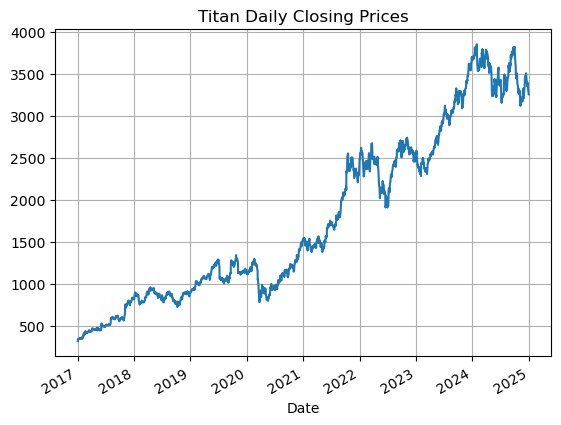

In [378]:
stock_prices.plot()
plt.title("Titan Daily Closing Prices")
plt.grid()

Despite some prices corrections, there appears to be a general rising trend in this stock over the years

Let us now look at the skew and kurtosis.

In [382]:
stock_prices.skew()

0.4788396459924155

In [384]:
stock_prices.kurtosis()

-1.1356475289698953

Let us now check for stationarity

In [387]:
adf_result = adfuller(stock_prices)
adf_statistic = adf_result[0] 
p_value = adf_result[1]
used_lags = adf_result[2] 
critical_values = adf_result[4] 

adf_statistic, p_value, used_lags, critical_values

(-0.6927549164710374,
 0.8486172629177092,
 4,
 {'1%': -3.433675467561267,
  '5%': -2.863008999826203,
  '10%': -2.5675520348463654})

The series is not stationary, as the p-value is greater than 0.05. The ADF statistic is also higher than all critical values.

Let us check for the presence of persistence in the series

In [391]:
for i in [1, 5, 10, 50, 100, 200, 500, 1000]:
    print(stock_prices.autocorr(lag = i))

0.9995098501235516
0.9974090942183587
0.994880270373017
0.9763846324044606
0.9581783377427333
0.9292831670282055
0.9138901418023251
0.8339297669499727


Clearly, high autocorrelation is present in the stock.

Text(0.5, 1.0, 'Histogram of Titan Closing Prices')

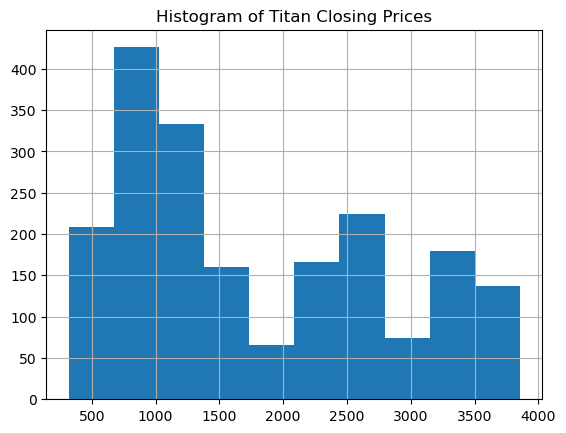

In [394]:
stock_prices.hist()
plt.title("Histogram of Titan Closing Prices")

Let us try to build predictive models on this dataset to predict future prices

Suppose we consider that data before 2023 should be used for training, and data 2023 onwards for testing, we get a 75:25 train-test split. We would have 1484 data points in the train set, and 490 in the test set.

In [398]:
train = stock_prices[stock_prices.index<"2023-01-01"]
test = stock_prices[stock_prices.index>"2023-01-01"]

In [400]:
len(train)/(len(train)+len(test))

0.75177304964539

In [402]:
len(train)

1484

In [404]:
len(test)

490

## 1. b and 1. c

Now, let us build models to forecast future prices of this stock. Here, there will be some leakage of data between the train and test data sets. I ensure data leakage in the following ways:
1. I scale the entire data before splitting it into train and test sets.
2. I use random shuffling in when performing cross-validation during training.

In [408]:
scaler = MinMaxScaler()
stock_prices_scaled = scaler.fit_transform(stock_prices.to_frame())

In [410]:
stock_prices_scaled

array([[0.        ],
       [0.00385415],
       [0.00697544],
       ...,
       [0.84973742],
       [0.84581804],
       [0.83114524]])

Now, the train-test split happens. Here, I use the train-test ratio described just a few cells above to achieve a 75:25 chronological split.

In [490]:
train_scaled = stock_prices_scaled[:1484]
test_scaled = stock_prices_scaled[1484:]

In [492]:
len(train_scaled)

1484

In [494]:
len(test_scaled)

490

First, I build an MLP model.

In [497]:
train_scaled = pd.DataFrame(train_scaled)
train_scaled.columns = ['Close']
test_scaled = pd.DataFrame(test_scaled)
test_scaled.columns = ['Close']

In [499]:
train_scaled

,Close
0,0.000000
1,0.003854
2,0.006975
3,0.006541
4,0.005768
...,...
1479,0.604554
1480,0.610844
1481,0.632307
1482,0.624770


<Axes: >

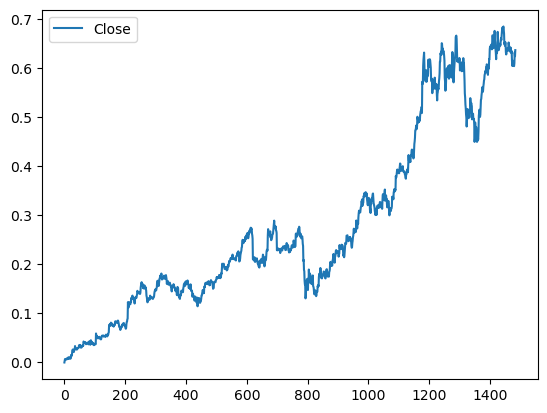

In [501]:
train_scaled.plot()

Let us build the features as well as the target for the model. Let the target be the price for the next day. Since the time series has autocorrelation and persistence, I will try to use values from the immediate past few days to predict the prices on the next day. Information from previous days will be incorporated using moving averages.

In [504]:
train_scaled["1d_lag"] = train_scaled["Close"].shift(1)
train_scaled["2d_mva"] = train_scaled["Close"].rolling(2).mean()
train_scaled["5d_mva"] = train_scaled["Close"].rolling(5).mean()
train_scaled["7d_mva"] = train_scaled["Close"].rolling(7).mean()
train_scaled["10d_mva"] = train_scaled["Close"].rolling(10).mean()
train_scaled["20d_mva"] = train_scaled["Close"].rolling(10).mean()
train_scaled["Target"] = train_scaled["Close"].shift(-1)
train_scaled

,Close,1d_lag,2d_mva,5d_mva,7d_mva,10d_mva,20d_mva,Target
0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.003854
1,0.003854,0.000000,0.001927,NaN,NaN,NaN,NaN,0.006975
2,0.006975,0.003854,0.005415,NaN,NaN,NaN,NaN,0.006541
3,0.006541,0.006975,0.006758,NaN,NaN,NaN,NaN,0.005768
4,0.005768,0.006541,0.006154,0.004628,NaN,NaN,NaN,0.005605
...,...,...,...,...,...,...,...,...
1479,0.604554,0.605100,0.604827,0.606762,0.607830,0.613751,0.613751,0.610844
1480,0.610844,0.604554,0.607699,0.606504,0.608659,0.611724,0.611724,0.632307
1481,0.632307,0.610844,0.621576,0.611578,0.610994,0.611417,0.611417,0.624770
1482,0.624770,0.632307,0.628539,0.615515,0.612800,0.612273,0.612273,0.637169


Now, let us drop all null values

In [507]:
train_scaled.dropna(inplace=True)

In [509]:
train_scaled

,Close,1d_lag,2d_mva,5d_mva,7d_mva,10d_mva,20d_mva,Target
9,0.006623,0.008075,0.007349,0.007008,0.006764,0.005818,0.005818,0.007844
10,0.007844,0.006623,0.007233,0.007456,0.006950,0.006602,0.006602,0.007057
11,0.007057,0.007844,0.007450,0.007374,0.007134,0.006923,0.006923,0.008970
12,0.008970,0.007057,0.008014,0.007714,0.007615,0.007122,0.007122,0.010517
13,0.010517,0.008970,0.009744,0.008202,0.008051,0.007520,0.007520,0.007260
...,...,...,...,...,...,...,...,...
1478,0.605100,0.605086,0.605093,0.609043,0.609495,0.616653,0.616653,0.604554
1479,0.604554,0.605100,0.604827,0.606762,0.607830,0.613751,0.613751,0.610844
1480,0.610844,0.604554,0.607699,0.606504,0.608659,0.611724,0.611724,0.632307
1481,0.632307,0.610844,0.621576,0.611578,0.610994,0.611417,0.611417,0.624770


Now, to build the MLP

In [512]:
tf.keras.backend.clear_session()  # We clear the backend to reset the random seed process
tf.random.set_seed(42)

act_fun = "relu"
hp_units_1 = 10
hp_units_2 = 12
hp_units_3 = 6
hp_units_4 = 4
#n_dropout = 0.2

In [513]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=hp_units_1, activation=act_fun, input_shape=(7,)))
#model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
#model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
#model.add(tf.keras.layers.Dropout(n_dropout)
model.add(tf.keras.layers.Dense(units=hp_units_4, activation=act_fun))
model.add(tf.keras.layers.Dense(units=1)) #activation function

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [514]:
hp_lr = 1e-4  # Learning rate
adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
model.compile(optimizer=adam, loss="mse", metrics=["mae"])

In [518]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=20,
    restore_best_weights=True,
)

In [520]:
X_train_scaled = train_scaled[['Close', '1d_lag', '2d_mva', '5d_mva', '7d_mva', '10d_mva', '20d_mva']]
y_train_scaled = train_scaled[['Target']]	

In [522]:
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=2,
    callbacks = [es],
)

Epoch 1/100
37/37 - 3s - 74ms/step - loss: 0.0382 - mae: 0.1702 - val_loss: 0.2453 - val_mae: 0.4930
Epoch 2/100
37/37 - 0s - 7ms/step - loss: 0.0330 - mae: 0.1558 - val_loss: 0.2230 - val_mae: 0.4699
Epoch 3/100
37/37 - 0s - 6ms/step - loss: 0.0281 - mae: 0.1410 - val_loss: 0.2005 - val_mae: 0.4455
Epoch 4/100
37/37 - 0s - 7ms/step - loss: 0.0235 - mae: 0.1266 - val_loss: 0.1784 - val_mae: 0.4200
Epoch 5/100
37/37 - 0s - 6ms/step - loss: 0.0192 - mae: 0.1128 - val_loss: 0.1568 - val_mae: 0.3937
Epoch 6/100
37/37 - 0s - 6ms/step - loss: 0.0155 - mae: 0.0997 - val_loss: 0.1364 - val_mae: 0.3670
Epoch 7/100
37/37 - 0s - 6ms/step - loss: 0.0123 - mae: 0.0876 - val_loss: 0.1176 - val_mae: 0.3405
Epoch 8/100
37/37 - 0s - 6ms/step - loss: 0.0097 - mae: 0.0761 - val_loss: 0.1006 - val_mae: 0.3148
Epoch 9/100
37/37 - 0s - 7ms/step - loss: 0.0077 - mae: 0.0658 - val_loss: 0.0858 - val_mae: 0.2905
Epoch 10/100
37/37 - 0s - 6ms/step - loss: 0.0062 - mae: 0.0580 - val_loss: 0.0733 - val_mae: 0.268

In [523]:
train_pred = model.predict(X_train_scaled)
r2_score(y_train_scaled, train_pred)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


0.9960023164749146

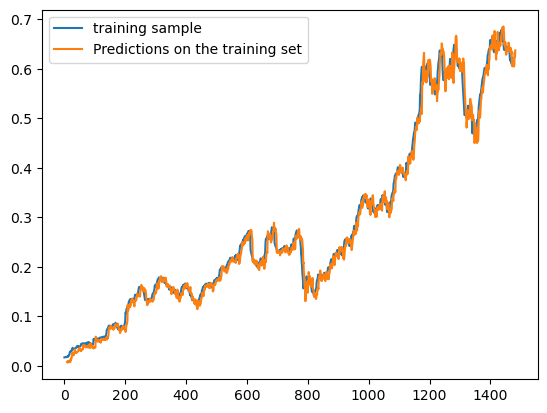

In [526]:
plt.plot(train_pred, label="training sample")
plt.plot(y_train_scaled, label="Predictions on the training set")
plt.legend()

Now, we test the model

In [528]:
test_scaled["1d_lag"] = test_scaled["Close"].shift(1)
test_scaled["2d_mva"] = test_scaled["Close"].rolling(2).mean()
test_scaled["5d_mva"] = test_scaled["Close"].rolling(5).mean()
test_scaled["7d_mva"] = test_scaled["Close"].rolling(7).mean()
test_scaled["10d_mva"] = test_scaled["Close"].rolling(10).mean()
test_scaled["20d_mva"] = test_scaled["Close"].rolling(10).mean()
test_scaled["Target"] = test_scaled["Close"].shift(-1)
test_scaled

,Close,1d_lag,2d_mva,5d_mva,7d_mva,10d_mva,20d_mva,Target
0,0.628272,NaN,NaN,NaN,NaN,NaN,NaN,0.641680
1,0.641680,0.628272,0.634976,NaN,NaN,NaN,NaN,0.637183
2,0.637183,0.641680,0.639431,NaN,NaN,NaN,NaN,0.627250
3,0.627250,0.637183,0.632216,NaN,NaN,NaN,NaN,0.620525
4,0.620525,0.627250,0.623887,0.630982,NaN,NaN,NaN,0.605548
...,...,...,...,...,...,...,...,...
485,0.870650,0.859133,0.864891,0.866875,0.874145,0.878862,0.878862,0.858326
486,0.858326,0.870650,0.864488,0.863892,0.867861,0.875400,0.875400,0.849737
487,0.849737,0.858326,0.854032,0.859430,0.863206,0.871154,0.871154,0.845818
488,0.845818,0.849737,0.847778,0.856733,0.859288,0.867290,0.867290,0.831145


In [530]:
test_scaled.dropna(inplace=True)

In [532]:
test_scaled

,Close,1d_lag,2d_mva,5d_mva,7d_mva,10d_mva,20d_mva,Target
9,0.586649,0.594887,0.590768,0.596067,0.604015,0.613524,0.613524,0.583469
10,0.583469,0.586649,0.585059,0.591651,0.597761,0.609044,0.609044,0.584058
11,0.584058,0.583469,0.583763,0.588274,0.592551,0.603282,0.603282,0.588583
12,0.588583,0.584058,0.586320,0.587529,0.590128,0.598422,0.598422,0.577641
13,0.577641,0.588583,0.583112,0.584080,0.586799,0.593461,0.593461,0.573788
...,...,...,...,...,...,...,...,...
484,0.859133,0.859302,0.859217,0.869210,0.876118,0.880879,0.880879,0.870650
485,0.870650,0.859133,0.864891,0.866875,0.874145,0.878862,0.878862,0.858326
486,0.858326,0.870650,0.864488,0.863892,0.867861,0.875400,0.875400,0.849737
487,0.849737,0.858326,0.854032,0.859430,0.863206,0.871154,0.871154,0.845818


In [534]:
X_test_scaled = test_scaled[['Close', '1d_lag', '2d_mva', '5d_mva', '7d_mva', '10d_mva', '20d_mva']]
y_test_scaled = test_scaled[['Target']]	

In [536]:
y_test_scaled

,Target
9,0.583469
10,0.584058
11,0.588583
12,0.577641
13,0.573788
...,...
484,0.870650
485,0.858326
486,0.849737
487,0.845818


In [538]:
y_pred = model.predict(X_test_scaled)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [540]:
r2_score(y_test_scaled, y_pred)

0.9764597415924072

In [604]:
y_test_og_scale = scaler.inverse_transform(y_test_scaled)
y_pred_og_scale = scaler.inverse_transform(y_pred)

Text(0.5, 1.0, 'MLP Model with Leakage - Titan Price Predictions')

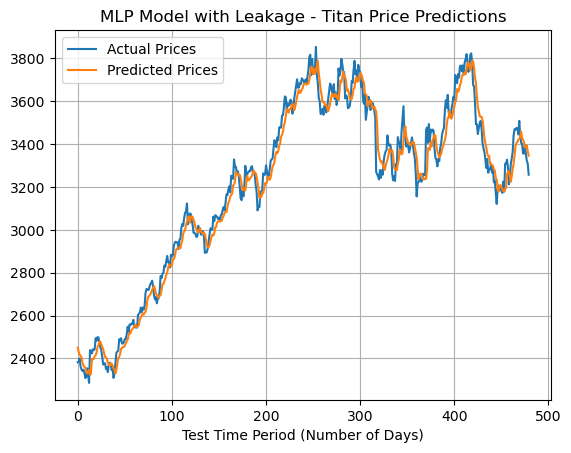

In [610]:
plt.plot(y_test_og_scale, label="Actual Prices")
plt.plot(y_pred_og_scale,label="Predicted Prices")
plt.legend()
plt.grid()
plt.xlabel("Test Time Period (Number of Days)")
plt.title("MLP Model with Leakage - Titan Price Predictions")

I have not inverse scaled the test data, nor added the dates as of now. But the r2 score on the test data is 0.93, which is impressive. But of course, there is plenty of data leakage here.

Now, I build an LSTM Model with data leakage.

In [612]:
train_scaled

,Close,1d_lag,2d_mva,5d_mva,7d_mva,10d_mva,20d_mva,Target
9,0.006623,0.008075,0.007349,0.007008,0.006764,0.005818,0.005818,0.007844
10,0.007844,0.006623,0.007233,0.007456,0.006950,0.006602,0.006602,0.007057
11,0.007057,0.007844,0.007450,0.007374,0.007134,0.006923,0.006923,0.008970
12,0.008970,0.007057,0.008014,0.007714,0.007615,0.007122,0.007122,0.010517
13,0.010517,0.008970,0.009744,0.008202,0.008051,0.007520,0.007520,0.007260
...,...,...,...,...,...,...,...,...
1478,0.605100,0.605086,0.605093,0.609043,0.609495,0.616653,0.616653,0.604554
1479,0.604554,0.605100,0.604827,0.606762,0.607830,0.613751,0.613751,0.610844
1480,0.610844,0.604554,0.607699,0.606504,0.608659,0.611724,0.611724,0.632307
1481,0.632307,0.610844,0.621576,0.611578,0.610994,0.611417,0.611417,0.624770


For this model, I will use the sequence of past 25 days data to predict future values (which is similar to the approach I followed in GWP2)

In [615]:
train_scaled = train_scaled["Close"]
test_scaled = test_scaled["Close"]

In [617]:
test_scaled

9      0.586649
10     0.583469
11     0.584058
12     0.588583
13     0.577641
         ...   
484    0.859133
485    0.870650
486    0.858326
487    0.849737
488    0.845818
Name: Close, Length: 480, dtype: float64

In [619]:
window_size = 25

In [621]:
X_train_scaled = []
y_train_scaled = [] 

X_test_scaled = []
y_test_scaled = [] 

for i in range(window_size, train_scaled.shape[0]):
    X_train_scaled.append(train_scaled[i-window_size: i])
    y_train_scaled.append(train_scaled[i])

for i in range(window_size, test_scaled.shape[0]):
    X_test_scaled.append(test_scaled[i-window_size: i])
    y_test_scaled.append(test_scaled[i])

#x_train, y_train = np.array(x_train), np.array(y_train) 

In [623]:
X_train_scaled, y_train_scaled = np.array(X_train_scaled), np.array(y_train_scaled) 
X_test_scaled, y_test_scaled = np.array(X_test_scaled), np.array(y_test_scaled)

In [625]:
seed = 42
n_dropout = 0
model = Sequential()
model.add(
    LSTM(
        units=128,
        return_sequences=True,
        activation="relu",
        input_shape=(X_train_scaled.shape[1], 1),
    )
)

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Now, I build the LSTM model

In [628]:
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=128, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(Dense(64))
model.add(Dense(1))

In [630]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 25, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 25, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 25, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 711,553 (2.71 MB)

 Trainable params: 711,553 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

In [632]:
hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=15, restore_best_weights=True
)

# fit the models
model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.15,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
20/20 - 12s - 611ms/step - loss: 0.1316 - val_loss: 0.0470
Epoch 2/100
20/20 - 3s - 147ms/step - loss: 0.0464 - val_loss: 0.0308
Epoch 3/100
20/20 - 3s - 146ms/step - loss: 0.0155 - val_loss: 0.0388
Epoch 4/100
20/20 - 3s - 146ms/step - loss: 0.0100 - val_loss: 0.0271
Epoch 5/100
20/20 - 3s - 147ms/step - loss: 0.0093 - val_loss: 0.0195
Epoch 6/100
20/20 - 3s - 146ms/step - loss: 0.0088 - val_loss: 0.0175
Epoch 7/100
20/20 - 3s - 148ms/step - loss: 0.0087 - val_loss: 0.0170
Epoch 8/100
20/20 - 3s - 147ms/step - loss: 0.0086 - val_loss: 0.0168
Epoch 9/100
20/20 - 3s - 147ms/step - loss: 0.0083 - val_loss: 0.0166
Epoch 10/100
20/20 - 3s - 147ms/step - loss: 0.0081 - val_loss: 0.0157
Epoch 11/100
20/20 - 3s - 146ms/step - loss: 0.0079 - val_loss: 0.0169
Epoch 12/100
20/20 - 3s - 148ms/step - loss: 0.0077 - val_loss: 0.0145
Epoch 13/100
20/20 - 3s - 148ms/step - loss: 0.0076 - val_loss: 0.0152
Epoch 14/100
20/20 - 3s - 148ms/step - loss: 0.0073 - val_loss: 0.0149
Epoch 15/100
2

In [633]:
train_pred = model.predict(X_train_scaled)
print("r2 score of the model on the in-sample set:", r2_score(y_train_scaled, train_pred))
print("correlation between the predicted values and the actual in-sample data:", np.corrcoef(y_train_scaled, train_pred.flatten()))

46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step
r2 score of the model on the in-sample set: 0.9983622926198287
correlation between the predicted values and the actual in-sample data: [[1.         0.99918754]
 [0.99918754 1.        ]]


In [634]:
y_pred = model.predict(X_test_scaled)
print("r2 score of the model on the out-of-sample test set:", r2_score(y_test_scaled, y_pred))
print("correlation between the predicted values and the actual in-sample data:", np.corrcoef(y_test_scaled, y_pred.flatten()))

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
r2 score of the model on the out-of-sample test set: 0.9827213829492972
correlation between the predicted values and the actual in-sample data: [[1.         0.99428642]
 [0.99428642 1.        ]]


In [643]:
y_test_og_scale = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
y_pred_og_scale = scaler.inverse_transform(y_pred.reshape(-1, 1))

Here, I get an r2 score of 0.99 on the test set. Again, data leakage exists here.

Text(0.5, 1.0, 'LSTM Model with Leakage - Titan Price Predictions')

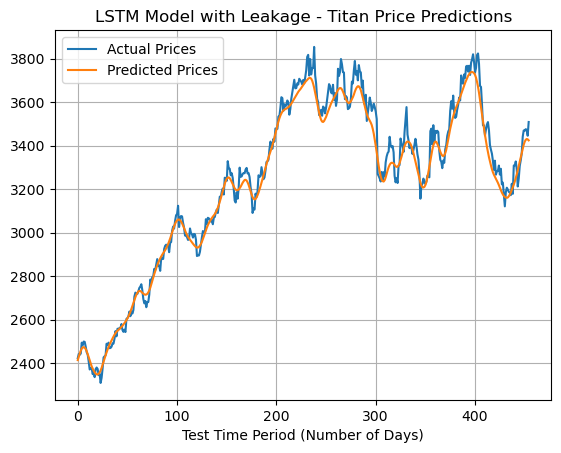

In [645]:
plt.plot(y_test_og_scale, label="Actual Prices")
plt.plot(y_pred_og_scale,label="Predicted Prices")
plt.legend()
plt.grid()
plt.xlabel("Test Time Period (Number of Days)")
plt.title("LSTM Model with Leakage - Titan Price Predictions")

## Step 2